In [5]:
import pandas as pd
import mysql.connector
import networkx as nx
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [6]:
def create_graph_from_sql(query, host="192.168.30.15", user="nms", password="Nms@1234", database="cnmsip"):
    """
    Create a NetworkX graph from SQL query data
    
    Parameters:
    -----------
    query : str
        SQL query to fetch network data
    host, user, password, database : str
        MySQL connection parameters
        
    Returns:
    --------
    G : NetworkX graph
        Graph created from the SQL data
    df : pandas DataFrame
        DataFrame containing the original SQL data
    """
    # Connect to MySQL
    conn = mysql.connector.connect(
        host=host,
        user=user,
        password=password,
        database=database
    )
    
    # Fetch data
    print(f"Executing query: {query}")
    df = pd.read_sql(query, conn)
    conn.close()
    
    print(f"Query returned {len(df)} rows")
    print(df.head())
    
    # Create an empty graph
    G = nx.Graph()
    
    # Add nodes and edges based on the data
    # Assuming aendip and bendip are node identifiers, and we're connecting them
    for _, row in df.iterrows():
        # Get node identifiers
        a_node = row['aendip']
        b_node = row['bendip']
        
        # Add nodes with attributes
        G.add_node(a_node, name=row['aendname'])
        G.add_node(b_node, name=row['bendname'])
        
        # Add other node attributes if available
       
        # Add edge with attributes
        
        G.add_edge(a_node, b_node,)
    
    print(f"Created graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G, df

In [7]:
query = """
SELECT 
*
FROM topology_data_logical 
WHERE physicalringname = "Berla_Pink";
"""
G_log,pd_log = create_graph_from_sql(query)

Executing query: 
SELECT 
*
FROM topology_data_logical 
WHERE physicalringname = "Berla_Pink";

Query returned 34 rows
     id physicalringname      lrname    aendname    bendname  distance  \
0  1758       BERLA_Pink  Ring no.07    LENGVARA       SARDA      3.80   
1  1759       BERLA_Pink  Ring no.07       SARDA     JAMGAON      4.06   
2  1760       BERLA_Pink  Ring no.07     JAMGAON     BAHINGA     21.19   
3  1761       BERLA_Pink  Ring no.07     BAHINGA  KHAMHARIYA     29.16   
4  1762       BERLA_Pink  Ring no.07  KHAMHARIYA  MOHABHATTA     12.69   

  ibclink priority  aendid  bendid  ...        bendip        aendip  \
0    None      Low    2813    2788  ...  10.128.17.72  10.128.17.58   
1    None      Low    2788    2791  ...  10.128.17.39  10.128.17.72   
2    None      Low    2791    2799  ...   10.128.17.5  10.128.17.39   
3    None      Low    2799    2800  ...  10.128.17.45   10.128.17.5   
4    None      Low    2800    2817  ...  10.128.17.60  10.128.17.45   

         

/tmp/ipykernel_21255/3631370467.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [8]:
query = """
SELECT 
*
FROM topology_data_physical 
WHERE ringname = "Berla_Pink";
"""
G_phy, pd_phy = create_graph_from_sql(query)

Executing query: 
SELECT 
*
FROM topology_data_physical 
WHERE ringname = "Berla_Pink";

Query returned 34 rows
     id    ringname ringnum ringcolor  segmentid  aendname   bendname  isspur  \
0  2852  BERLA_Pink    None      None      12993     BERLA    TARALIM       0   
1  2853  BERLA_Pink    None      None      12994   TARALIM   LENGVARA       0   
2  2854  BERLA_Pink    None      None      12995  LENGVARA      SARDA       0   
3  2855  BERLA_Pink    None      None      12996     SARDA   BHATGAON       0   
4  2856  BERLA_Pink    None      None      12997  BHATGAON  BAWANLAKH       0   

   isjc  aendid  bendid        aendip        bendip  color  \
0     0    2511    3052   10.128.0.16  10.128.17.82  Green   
1     0    3052    2813  10.128.17.82  10.128.17.58  Green   
2     0    2813    2788  10.128.17.58  10.128.17.72  Green   
3     0    2788    2760  10.128.17.72  10.128.17.14  Green   
4     0    2760    2752  10.128.17.14  10.128.17.86  Green   

              logtime      a

/tmp/ipykernel_21255/3631370467.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [14]:
print("Number of nodes in G_phy:", G_phy.number_of_nodes())
print("Number of edges in G_phy:", G_phy.number_of_edges())

Number of nodes in G_phy: 32
Number of edges in G_phy: 34


In [18]:
def parse_xy(coord_str):
    """Parse a coordinate string in the form 'x;y' into a dict with keys 'x' and 'y'."""
    try:
        x, y = map(float, coord_str.split(';'))
        return {'x': x, 'y': y}
    except Exception as e:
        print(f"Error parsing coordinates '{coord_str}': {e}")
        return None

def create_combined_physical_logical_graph(G_phy, logical_connections_df, pd_phy):
    """
    Create a MultiGraph with logical overlays and store XY coordinates from pd_phy
    
    Parameters:
    -----------
    G_phy : NetworkX Graph
        The physical topology graph
    logical_connections_df : DataFrame
        DataFrame containing logical connections (with aendip, bendip, etc.)
    pd_phy : DataFrame
        DataFrame containing physical topology data with 'aendxy' and 'bendxy' columns
        
    Returns:
    --------
    G_combined : NetworkX MultiGraph
        Graph with logical connections (logical segments) and node XY coordinates
    """
    import networkx as nx
    
    # Create a MultiGraph to hold both types of connections
    G_combined = nx.MultiGraph()
    
    # Add all nodes from G_phy (and later update with XY coordinates)
    for node, attrs in G_phy.nodes(data=True):
        G_combined.add_node(node, **attrs)
    
    # Before adding logical edges, update nodes with XY coordinates from pd_phy.
    # We assume that for each row in pd_phy, the coordinates apply to the end nodes.
    for idx, row in pd_phy.iterrows():
        a_node = row.get('aendip')
        b_node = row.get('bendip')
        a_name = row.get('aendname')
        b_name = row.get('bendname')
        G_combined.nodes[a_node]['name'] = a_name
        G_combined.nodes[b_node]['name'] = b_name
        # Parse and update aendxy for a_node
        a_coords = parse_xy(row.get('aendxy', ''))
        if a_coords and a_node in G_combined.nodes:
            G_combined.nodes[a_node].update(a_coords)
        
        # Parse and update bendxy for b_node
        b_coords = parse_xy(row.get('bendxy', ''))
        if b_coords and b_node in G_combined.nodes:
            G_combined.nodes[b_node].update(b_coords)
    
    # Note: We are not adding physical edges in G_combined
    
    # For each logical connection, find the physical path and add logical edges (segments)
    for _, row in logical_connections_df.iterrows():
        source = row['aendip']
        target = row['bendip']
    
        # Skip if nodes don't exist in the physical graph
        if source not in G_phy.nodes or target not in G_phy.nodes:
            print(f"Warning: Nodes {source} or {target} not in physical graph")
            continue
        
        # Find physical path for this logical connection using the physical graph (G_phy)
        try:
            physical_path = nx.shortest_path(G_phy, source, target)
            
            # Add edges between consecutive nodes in the physical path as logical segments
            for i in range(len(physical_path)-1):
                node1 = physical_path[i]
                node2 = physical_path[i+1]
                
                # Create a unique key for this segment of the logical path
                segment_key = f"{source}-{target}_{i}"
                
                if not G_combined.has_edge(node1, node2, key=segment_key):
                    G_combined.add_edge(
                        node1,
                        node2,
                        key=segment_key,
                        connection_type='logical_segment',
                        logical_name=row.get('lrname', 'unknown'),
                        segment_index=i,
                        source_endpoint=source,
                        target_endpoint=target
                    )
            
        except nx.NetworkXNoPath:
            print(f"No physical path found between {source} and {target}")
    
    print(f"Created combined graph with {G_combined.number_of_nodes()} nodes and {G_combined.number_of_edges()} edges")
    return G_combined

In [42]:
G_combined = create_combined_physical_logical_graph(G_phy,pd_log, pd_phy)

Created combined graph with 32 nodes and 110 edges


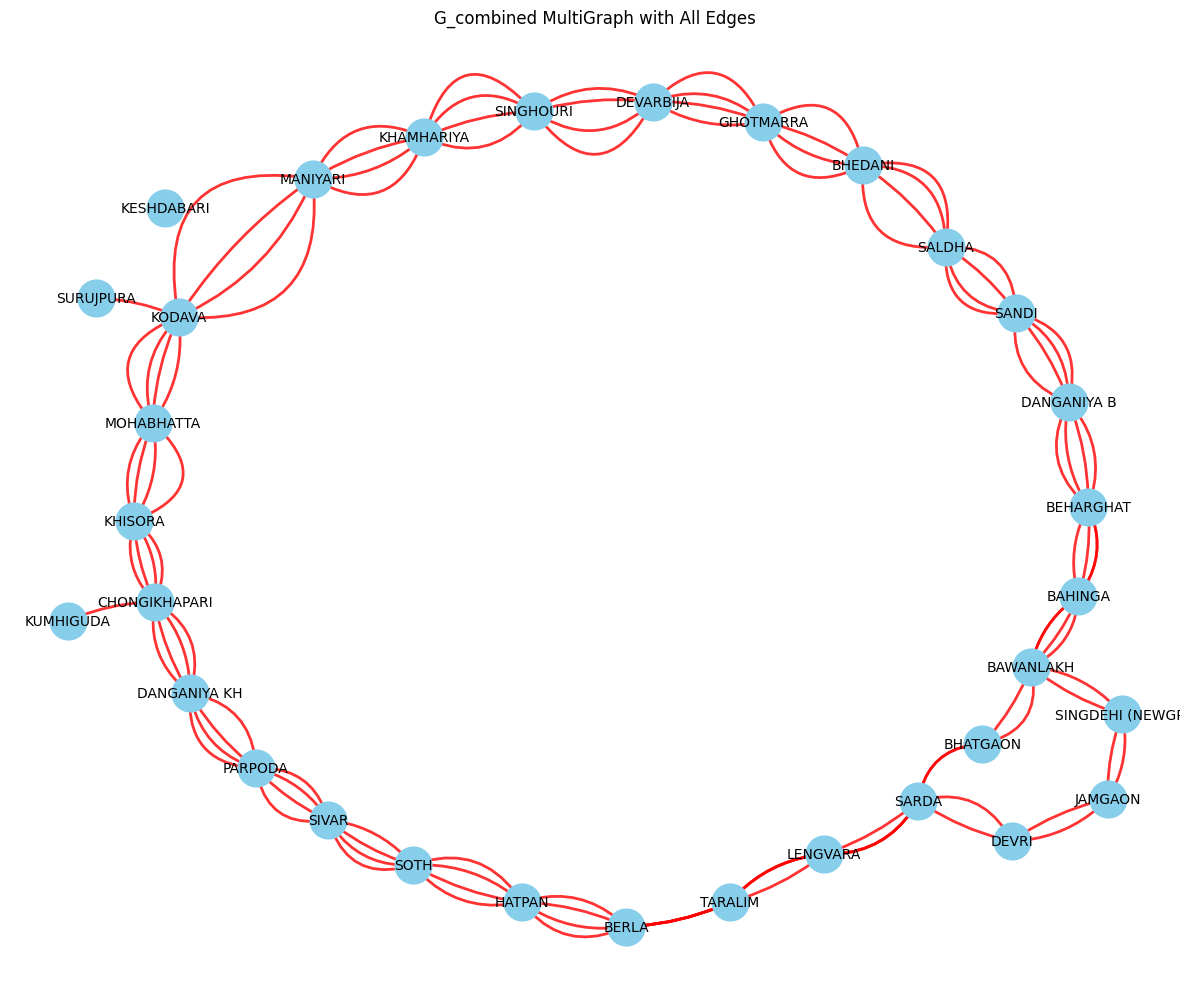

In [21]:
import matplotlib.pyplot as plt
import networkx as nx

# Compute positions for all nodes. 
# If your nodes already have 'x' and 'y' attributes, you can use them:
pos = {}
for node, data in G_combined.nodes(data=True):
    if 'x' in data and 'y' in data:
        pos[node] = (data['x'], data['y'])
if len(pos) < G_combined.number_of_nodes():
    # Fallback to spring layout for nodes missing fixed positions
    pos.update(nx.spring_layout(G_combined, seed=42))

plt.figure(figsize=(12, 10))
node_labels = {}
for node, data in G_combined.nodes(data=True):
    node_labels[node] = data.get('name', str(node))  
# Draw nodes and labels
nx.draw_networkx_nodes(G_combined, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_labels(G_combined, pos, font_size=10,labels=node_labels)

# Draw each edge individually to handle multiple (parallel) edges.
for u, v, key, data in G_combined.edges(data=True, keys=True):
    # Determine curvature (rad) based on the key. If key contains an index, use it.
    try:
        # Assume key is formatted like "source-target_i"
        index = int(key.split('_')[-1])
        # Alternate curvature sign for even/odd indices to offset edges on both sides
        rad = (0.1 * (index + 1)) * (1 if index % 2 == 0 else -1)
    except Exception:
        rad = 0.1

    # Choose edge color based on connection type
    conn_type = data.get('connection_type', 'unknown')
    if conn_type == 'logical_segment':
        edge_color = 'red'
    else:
        edge_color = 'black'

    # Draw this single edge with a curved connection style
    nx.draw_networkx_edges(
        G_combined, pos,
        edgelist=[(u, v)],
        edge_color=edge_color,
        connectionstyle=f'arc3, rad={rad}',
        width=2,
        alpha=0.8
    )

plt.title("G_combined MultiGraph with All Edges")
plt.axis('off')
plt.tight_layout()
plt.show()

In [22]:
def remove_logical_connection(G, source_ip, target_ip):
    """
    Remove all edges corresponding to a specific logical connection from the graph.
    
    Parameters:
    -----------
    G : NetworkX MultiGraph
        The graph containing logical connections
    source_ip : str
        The source endpoint IP of the logical connection to remove
    target_ip : str
        The target endpoint IP of the logical connection to remove
        
    Returns:
    --------
    G : NetworkX MultiGraph
        The modified graph with the specified logical connection removed
    """
    # Create a list of edges to remove (can't modify during iteration)
    edges_to_remove = []
    
    # Find all edges that are part of this logical connection
    for u, v, key, data in G.edges(data=True, keys=True):
        # Option 1: Check by key format
        if key.startswith(f"{source_ip}-{target_ip}_") or key.startswith(f"{target_ip}-{source_ip}_"):
            edges_to_remove.append((u, v, key))
        
        # Option 2: Check by source/target endpoint attributes
        elif (data.get('connection_type') == 'logical_segment' and 
              ((data.get('source_endpoint') == source_ip and data.get('target_endpoint') == target_ip) or
               (data.get('source_endpoint') == target_ip and data.get('target_endpoint') == source_ip))):
            edges_to_remove.append((u, v, key))
    
    # Remove the edges
    for u, v, key in edges_to_remove:
        G.remove_edge(u, v, key)
    
    print(f"Removed {len(edges_to_remove)} edges for logical connection {source_ip} - {target_ip}")
    return G

In [28]:
pd_phy

,id,ringname,ringnum,ringcolor,segmentid,aendname,bendname,isspur,isjc,aendid,bendid,aendip,bendip,color,logtime,aendxy,bendxy,bypass,bypassgp,bypass_lrdata
0,2852,BERLA_Pink,None,None,12993,BERLA,TARALIM,0,0,2511,3052,10.128.0.16,10.128.17.82,Green,2025-03-18 13:16:53,349;-2331,550;-2279,0,None,None
1,2853,BERLA_Pink,None,None,12994,TARALIM,LENGVARA,0,0,3052,2813,10.128.17.82,10.128.17.58,Green,2025-03-18 13:16:53,550;-2279,732;-2177,0,None,None
2,2854,BERLA_Pink,None,None,12995,LENGVARA,SARDA,0,0,2813,2788,10.128.17.58,10.128.17.72,Green,2025-03-18 13:16:53,732;-2177,915;-2063,0,None,None
3,2855,BERLA_Pink,None,None,12996,SARDA,BHATGAON,0,0,2788,2760,10.128.17.72,10.128.17.14,Green,2025-03-18 13:16:53,915;-2063,1039;-1942,0,None,None
4,2856,BERLA_Pink,None,None,12997,BHATGAON,BAWANLAKH,0,0,2760,2752,10.128.17.14,10.128.17.86,Green,2025-03-18 13:16:53,1039;-1942,1133;-1777,0,None,None
5,2857,BERLA_Pink,None,None,12998,BAWANLAKH,BAHINGA,0,0,2752,2799,10.128.17.86,10.128.17.5,Green,2025-03-18 13:16:53,1133;-1777,1225;-1627,0,None,None
6,2858,BERLA_Pink,None,None,12999,BAHINGA,BEHARGHAT,0,0,2799,2746,10.128.17.5,10.128.17.87,Green,2025-03-18 13:16:53,1225;-1627,1244;-1436,0,None,None
7,2859,BERLA_Pink,None,None,13000,BEHARGHAT,DANGANIYA B,0,0,2746,2781,10.128.17.87,10.128.17.24,Green,2025-03-18 13:16:53,1244;-1436,1206;-1213,0,None,None
8,2860,BERLA_Pink,None,None,13001,DANGANIYA B,SANDI,0,0,2781,2794,10.128.17.24,10.128.17.70,Green,2025-03-18 13:16:53,1206;-1213,1104;-1023,0,None,None
9,2861,BERLA_Pink,None,None,13002,SANDI,SALDHA,0,0,2794,2803,10.128.17.70,10.128.17.69,Green,2025-03-18 13:16:53,1104;-1023,968;-882,0,None,None


Removed 2 edges for logical connection 10.128.17.91 - 10.128.17.28
Edge count before: 108, after: 106


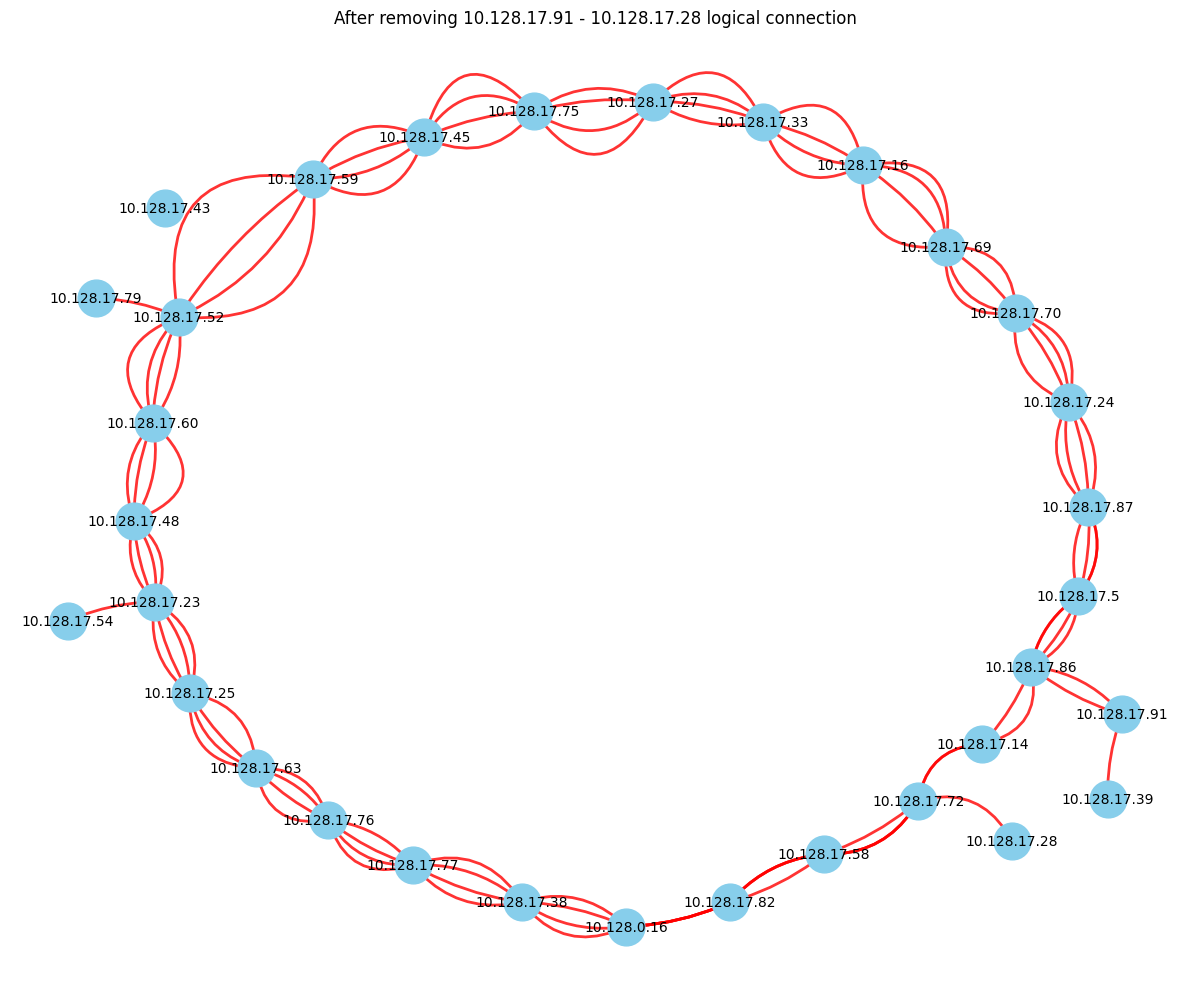

In [47]:
target_ip  = "10.128.17.28"  # Example IP (replace with actual value)
source_ip= "10.128.17.91"  # Example IP (replace with actual value)

# Get count of edges before removal
edge_count_before = G_combined.number_of_edges()

# Remove the logical connection
G_combined = remove_logical_connection(G_combined, source_ip, target_ip)

# Get count of edges after removal
edge_count_after = G_combined.number_of_edges()
print(f"Edge count before: {edge_count_before}, after: {edge_count_after}")

# Replot the graph to see the result
plt.figure(figsize=(12, 10))

# Draw nodes
nx.draw_networkx_nodes(G_combined, pos, node_size=700, node_color='skyblue')
nx.draw_networkx_labels(G_combined, pos, font_size=10)

# Draw remaining edges
for u, v, key, data in G_combined.edges(data=True, keys=True):
    try:
        index = int(key.split('_')[-1])
        rad = (0.1 * (index + 1)) * (1 if index % 2 == 0 else -1)
    except Exception:
        rad = 0.1
        
    conn_type = data.get('connection_type', 'unknown')
    edge_color = 'red' if conn_type == 'logical_segment' else 'black'
    
    nx.draw_networkx_edges(
        G_combined, pos,
        edgelist=[(u, v)],
        edge_color=edge_color,
        connectionstyle=f'arc3, rad={rad}',
        width=2,
        alpha=0.8
    )

plt.title(f"After removing {source_ip} - {target_ip} logical connection")
plt.axis('off')
plt.tight_layout()
plt.show()

In [39]:
for node, data in G_combined.nodes(data=True):
    print(node, data)

10.128.0.16 {'name': 'BERLA', 'x': 349.0, 'y': -2331.0}
10.128.17.82 {'name': 'TARALIM', 'x': 550.0, 'y': -2279.0}
10.128.17.58 {'name': 'LENGVARA', 'x': 732.0, 'y': -2177.0}
10.128.17.72 {'name': 'SARDA', 'x': 915.0, 'y': -2063.0}
10.128.17.14 {'name': 'BHATGAON', 'x': 1039.0, 'y': -1942.0}
10.128.17.86 {'name': 'BAWANLAKH', 'x': 1133.0, 'y': -1777.0}
10.128.17.5 {'name': 'BAHINGA', 'x': 1225.0, 'y': -1627.0}
10.128.17.87 {'name': 'BEHARGHAT', 'x': 1244.0, 'y': -1436.0}
10.128.17.24 {'name': 'DANGANIYA B', 'x': 1206.0, 'y': -1213.0}
10.128.17.70 {'name': 'SANDI', 'x': 1104.0, 'y': -1023.0}
10.128.17.69 {'name': 'SALDHA', 'x': 968.0, 'y': -882.0}
10.128.17.16 {'name': 'BHEDANI', 'x': 808.0, 'y': -709.0}
10.128.17.33 {'name': 'GHOTMARRA', 'x': 614.0, 'y': -616.0}
10.128.17.27 {'name': 'DEVARBIJA', 'x': 401.0, 'y': -573.0}
10.128.17.75 {'name': 'SINGHOURI', 'x': 170.0, 'y': -594.0}
10.128.17.45 {'name': 'KHAMHARIYA', 'x': -42.0, 'y': -649.0}
10.128.17.59 {'name': 'MANIYARI', 'x': -258.0,

In [50]:
def find_completely_missing_edges(G_single, G_multi):
    """
    Find node pairs that have an edge in G_single but have no edges at all in G_multi.
    
    Parameters:
    -----------
    G_single : NetworkX Graph
        A graph with single edges between nodes
    G_multi : NetworkX MultiGraph
        A multi-graph which may have multiple edges between nodes
        
    Returns:
    --------
    list of tuples
        List of (u, v, data) tuples representing edges in G_single that have
        no corresponding edge (of any kind) in G_multi
    """
    completely_missing = []
    
    # Check each edge in the single-edge graph
    for u, v, data in G_single.edges(data=True):
   # Check if there is ANY edge between these nodes in the multi-edge graph
        if not G_multi.has_edge(u, v):
            
            u_name = G_single.nodes[u].get('name', str(u))
            v_name = G_single.nodes[v].get('name', str(v)) 
            completely_missing.append((u, v,u_name,v_name ,data))
    return completely_missing

In [51]:
find_completely_missing_edges(G_phy, G_combined)

[('10.128.17.59', '10.128.17.43', 'MANIYARI', 'KESHDABARI', {}),
 ('10.128.17.43', '10.128.17.52', 'KESHDABARI', 'KODAVA', {}),
 ('10.128.17.39', '10.128.17.28', 'JAMGAON', 'DEVRI', {})]

In [52]:
pd_log

,id,physicalringname,lrname,aendname,bendname,distance,ibclink,priority,aendid,bendid,...,bendip,aendip,physicalsegments,remarks,confirmed,user_name,time_stamp,cluster_name,district_name,block_name
0,1758,BERLA_Pink,Ring no.07,LENGVARA,SARDA,3.800,None,Low,2813,2788,...,10.128.17.72,10.128.17.58,12995,None,1,Shiva,2024-12-07 13:05:44,A2,BEMETARA,BERLA
1,1759,BERLA_Pink,Ring no.07,SARDA,JAMGAON,4.060,None,Low,2788,2791,...,10.128.17.39,10.128.17.72,"13024,13025",None,1,Shiva,2024-12-07 13:06:21,A2,BEMETARA,BERLA
2,1760,BERLA_Pink,Ring no.07,JAMGAON,BAHINGA,21.190,None,Low,2791,2799,...,10.128.17.5,10.128.17.39,"13023,13022,12998",None,1,Shiva,2024-12-07 13:06:59,A2,BEMETARA,BERLA
3,1761,BERLA_Pink,Ring no.07,BAHINGA,KHAMHARIYA,29.160,None,Low,2799,2800,...,10.128.17.45,10.128.17.5,"12999,13000,13001,13002,13003,13004,13005,1300...",None,1,Shiva,2024-12-07 13:07:43,A2,BEMETARA,BERLA
4,1762,BERLA_Pink,Ring no.07,KHAMHARIYA,MOHABHATTA,12.690,None,Low,2800,2817,...,10.128.17.60,10.128.17.45,"13008,13143,13011",None,1,Shiva,2024-12-07 13:08:17,A2,BEMETARA,BERLA
5,1763,BERLA_Pink,Ring no.07,MOHABHATTA,SIVAR,25.130,None,Low,2817,2776,...,10.128.17.76,10.128.17.60,"13012,13013,13014,13015,13016",None,1,Shiva,2024-12-07 13:09:10,A2,BEMETARA,BERLA
6,1764,BERLA_Pink,Ring no.07,SIVAR,Berla,12.065,None,Low,2776,2511,...,10.128.0.16,10.128.17.76,"13017,13018,13019",None,1,Shiva,2024-12-07 13:12:37,A2,BEMETARA,BERLA
7,1765,BERLA_Pink,Ring no.08,Berla,BHATGAON,14.490,None,Low,2511,2760,...,10.128.17.14,10.128.0.16,"12993,12994,12995,12996",None,1,Shiva,2024-12-07 13:13:26,A2,BEMETARA,BERLA
8,1766,BERLA_Pink,Ring no.08,BHATGAON,BEHARGHAT,18.610,None,Low,2760,2746,...,10.128.17.87,10.128.17.14,"12997,12998,12999",None,1,Shiva,2024-12-07 13:14:49,A2,BEMETARA,BERLA
9,1767,BERLA_Pink,Ring no.08,BEHARGHAT,DANGANIYA B,2.580,None,Low,2746,2781,...,10.128.17.24,10.128.17.87,13000,None,1,Shiva,2024-12-07 13:15:31,A2,Bemetara,Berla


In [56]:
def create_edge_dictionary(G):
    """
    Create a dictionary with edge IP tuples as keys and 0 as values.
    
    Parameters:
    -----------
    G : NetworkX Graph or MultiGraph
        The graph containing the edges
        
    Returns:
    --------
    dict
        Dictionary with (u, v) IP tuples as keys and 0 as values
    """
    edge_dict = {}
    
    # For each edge in the graph
    for u, v in G.edges():
        # Create a tuple of the two IP addresses
        edge_tuple = (u, v)
        
        # Add to dictionary with value 0
        edge_dict[edge_tuple] = 0
        
        # If the graph is undirected, also add the reverse edge
        # Comment this out if you only want one direction
        edge_tuple_rev = (v, u)
        edge_dict[edge_tuple_rev] = 0
    
    return edge_dict

In [58]:
edge_dict = create_edge_dictionary(G_combined)
edge_dict

{('10.128.0.16', '10.128.17.38'): 0,
 ('10.128.17.38', '10.128.0.16'): 0,
 ('10.128.0.16', '10.128.17.82'): 0,
 ('10.128.17.82', '10.128.0.16'): 0,
 ('10.128.17.82', '10.128.17.58'): 0,
 ('10.128.17.58', '10.128.17.82'): 0,
 ('10.128.17.58', '10.128.17.72'): 0,
 ('10.128.17.72', '10.128.17.58'): 0,
 ('10.128.17.72', '10.128.17.28'): 0,
 ('10.128.17.28', '10.128.17.72'): 0,
 ('10.128.17.72', '10.128.17.14'): 0,
 ('10.128.17.14', '10.128.17.72'): 0,
 ('10.128.17.14', '10.128.17.86'): 0,
 ('10.128.17.86', '10.128.17.14'): 0,
 ('10.128.17.86', '10.128.17.91'): 0,
 ('10.128.17.91', '10.128.17.86'): 0,
 ('10.128.17.86', '10.128.17.5'): 0,
 ('10.128.17.5', '10.128.17.86'): 0,
 ('10.128.17.5', '10.128.17.87'): 0,
 ('10.128.17.87', '10.128.17.5'): 0,
 ('10.128.17.87', '10.128.17.24'): 0,
 ('10.128.17.24', '10.128.17.87'): 0,
 ('10.128.17.24', '10.128.17.70'): 0,
 ('10.128.17.70', '10.128.17.24'): 0,
 ('10.128.17.70', '10.128.17.69'): 0,
 ('10.128.17.69', '10.128.17.70'): 0,
 ('10.128.17.69', '1

In [ ]:
pd_log.to_csv("Berla_Pink_logical.csv",)

: 